In [28]:
# Generic libraries
import numpy as np
import pandas as pd
import scipy as sp
import tqdm
import seaborn as sns

%matplotlib notebook
from ipywidgets import *
import matplotlib.pyplot as plt
plt.style.context('seaborn')
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker as mtick
from collections import namedtuple
from tabulate import tabulate
from IPython.display import Latex
from IPython.display import HTML
from IPython.core.pylabtools import figsize
from matplotlib import rc
from scipy.spatial.distance import squareform
from itertools import product
import inspect
import multiprocessing
import time
import os
import glob

In [4]:
# MDAnalysis
import MDAnalysis as mda
from MDAnalysis.coordinates.base import Timestep
from MDAnalysis.lib import distances
from MDAnalysis.analysis.base import analysis_class
from MDAnalysis.lib.distances import capped_distance, self_capped_distance
from MDAnalysis.lib.distances import distance_array, self_distance_array
from MDAnalysis.analysis import contacts
from MDAnalysis.analysis import pca, align


/home/kryohi/.miniconda3/envs/mdanal/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")


In [6]:
## Import common data (e.g. pdb and psf files)
from pathlib import Path
simdir = Path('../data/00-external/')
PDB = simdir / '5Y36.pdb'
GRO = simdir / '5Y36_box.gro'

# set paths for output
plotpath = "../plots/"
datapath = "../data/analysis/"
output_name = "prod_global_"


In [7]:
## import full trajectory data 
trajdir = '../data/04-prod/'
XTC = trajdir + 'cas9_prod_pbc_all.xtc'

## universe creation
u = mda.Universe(str(GRO), str(XTC))
#u_new = u.copy() # used as a reference in memory for mapping calculations
#ref0 = mda.Universe(str(GRO))
print(u.select_atoms("protein or name MG").n_atoms, 'protein atoms')

# other info
box = u.dimensions
print('box dimensions:', box)
nframes = u.trajectory.n_frames
print(nframes, 'frames')
dt = u.trajectory.dt # ns per frame, equal to nstxout*0.002
time = np.arange(0, dt*nframes, dt)
t_ns = time / 1000
print(t_ns[-1], 'ns')


22526 protein atoms
box dimensions: [183.38486  183.38486  183.38478   60.000008  60.000008  90.      ]
5901 frames
295.0 ns


In [5]:
aligner = align.AlignTraj(u, u, select='backbone', in_memory=True).run()

In [6]:
# !! requires a lot of memory (~5GB) !!
# TODO check why it does not work for backbone
pc = pca.PCA(
    u, select='protein and name CA', align=False, mean=None, n_components=None, verbose=True).run(
    start=1, stop=nframes-1)


Mean Calculation:   0%|          | 0/5899 [00:00<?, ?it/s]

  0%|          | 0/5899 [00:00<?, ?it/s]

In [7]:
print(pc.results.cumulated_variance[0])
print(pc.results.cumulated_variance[1])
print(pc.results.cumulated_variance[2])
print(pc.results.cumulated_variance[3])
print(pc.results.cumulated_variance[4])
print(pc.results.cumulated_variance[20])

0.2960723669335334
0.42659199896814476
0.49952522238416747
0.5619793392898921
0.6079610254009219
0.6343712063254767
0.8067186049897174


In [18]:
backbone = u.select_atoms('protein and name CA')
ncomp = 20 # manually chosen in order to include 80% of the variance
transformed = pc.transform(backbone, n_components=ncomp)
print(transformed.shape)
df = pd.DataFrame(transformed, columns=['PC{}'.format(i+1) for i in range(ncomp)])
df.insert(loc=0, column='Time (ns)', value=t_ns)

(5901, 20)


,Time (ns),PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
0,0.00,20.341940,-13.991471,-29.153637,-11.754572,-95.874904,10.436064,-17.055206,-27.308711,-9.632252,...,-8.400663,-3.191718,-2.229890,-13.955938,-18.134139,2.906803,12.090916,-0.952702,6.915188,16.657688
1,0.05,25.407916,-7.404990,-22.984304,-5.448611,-92.559911,12.418405,-12.249327,-18.573039,-9.614544,...,1.286687,2.935151,-4.765044,-20.635992,-20.101889,4.873897,12.266616,2.472550,8.548764,10.506627
2,0.10,33.521373,-8.608740,-36.070996,-17.911398,-93.519977,7.912680,-13.663795,-22.998613,-10.056601,...,8.457831,-0.541143,-4.892977,-19.974169,-15.100945,1.561544,14.757197,1.512625,0.727823,15.682284
3,0.15,34.001239,2.767201,-32.811431,-11.080300,-95.596439,4.558413,-15.217825,-19.839768,-7.885050,...,8.778486,5.942574,-5.327123,-16.147176,-13.564212,6.923936,9.447907,-0.869358,-2.002718,15.053274
4,0.20,32.453001,-1.083703,-34.268702,-16.355757,-88.824462,9.003060,-18.243346,-16.783963,-14.208275,...,0.805699,4.824712,-4.895600,-14.210405,-15.084263,13.644559,13.583128,0.442006,0.805097,18.902249


In [19]:
# save ordered principal components for later use
df.to_pickle(datapath+"pca.pkl")
df.to_csv(datapath+"pca.csv", sep='\t', encoding='utf-8', index=False)

In [8]:
df = pd.read_csv(datapath+'pca.csv', index_col=0, sep="\t")
df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
Time (ns),,,,,,,,,,,,,,,,,,,,
0.00,20.341940,-13.991471,-29.153637,-11.754572,-95.874904,10.436064,-17.055206,-27.308711,-9.632252,11.075250,-8.400663,-3.191718,-2.229890,-13.955938,-18.134139,2.906803,12.090916,-0.952702,6.915188,16.657688
0.05,25.407916,-7.404990,-22.984304,-5.448611,-92.559911,12.418405,-12.249327,-18.573039,-9.614544,15.510026,1.286687,2.935151,-4.765044,-20.635992,-20.101889,4.873897,12.266616,2.472550,8.548764,10.506627
0.10,33.521373,-8.608740,-36.070996,-17.911398,-93.519977,7.912680,-13.663795,-22.998613,-10.056601,15.140625,8.457831,-0.541143,-4.892977,-19.974169,-15.100945,1.561544,14.757197,1.512625,0.727823,15.682284
0.15,34.001239,2.767201,-32.811431,-11.080300,-95.596439,4.558413,-15.217825,-19.839768,-7.885050,13.438078,8.778486,5.942574,-5.327123,-16.147176,-13.564212,6.923936,9.447907,-0.869358,-2.002718,15.053274
0.20,32.453001,-1.083703,-34.268702,-16.355757,-88.824462,9.003060,-18.243346,-16.783963,-14.208275,8.416028,0.805699,4.824712,-4.895600,-14.210405,-15.084263,13.644559,13.583128,0.442006,0.805097,18.902249


In [11]:
# very slow, use Makie version instead

#%matplotlib notebook
#g = sns.PairGrid(df, hue='Time (ps)', palette=sns.color_palette('Oranges_d', n_colors=len(df)));

In [12]:
#_ = g.map(plt.scatter, marker='.');
#g.savefig(plotpath+"pairplot_pca.pdf")


## Autocorrelation

In [9]:
## autocorrelation estimate for box-averaging
def autocorrelation(x):
    n = len(x)
    variance = x.var()
    x = x-x.mean()
    #r = np.array([(x[:n-k]*x[-(n-k):]).sum() for k in range(n)]) #slow method using the definition
    r = np.correlate(x, x, mode = 'full')[-n:] # fast method, same result!
    result = r/(variance*(np.arange(n, 0, -1)))
    return result

In [25]:
nlog = len(df)
t_acf = df.index[1:nlog//2]
print(nlog)
    
acf1 = autocorrelation(df['PC1'])
acf2 = autocorrelation(df['PC2'])
acf3 = autocorrelation(df['PC3'])
acf4 = autocorrelation(df['PC4'])
acf5 = autocorrelation(df['PC5'])


5901


<IPython.core.display.Javascript object>


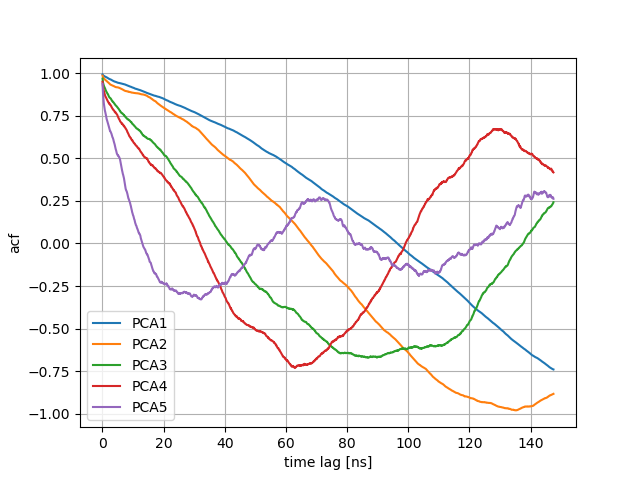

In [26]:
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(t_acf, acf1[1:nlog//2], label=r"PCA1")
ax.plot(t_acf, acf2[1:nlog//2], label=r"PCA2")
ax.plot(t_acf, acf3[1:nlog//2], label=r"PCA3")
ax.plot(t_acf, acf4[1:nlog//2], label=r"PCA4")
ax.plot(t_acf, acf5[1:nlog//2], label=r"PCA5")
plt.xlabel("time lag [ns]")
plt.ylabel("acf")
plt.grid()
plt.legend()
plt.savefig(os.path.join(plotpath, output_name+'_pca_acf.pdf'))